In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Paths
source_dir = '/kaggle/input/breastcancer-datasets/Breast Cancer Patients MRI/Breast Cancer Patients MRI'
output_dir = '/kaggle/working/split_MRI_dataset'

# Make sure this matches the actual class folder names inside your source_dir
classes_to_use = ['Benign', 'Malignant']

# Create target dirs
for split in ['train', 'val', 'test']:
    for cls in classes_to_use:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split and copy images
for cls in classes_to_use:
    cls_dir = os.path.join(source_dir, cls)
    all_images = os.listdir(cls_dir)
    random.shuffle(all_images)

    train_files, temp_files = train_test_split(all_images, train_size=train_ratio, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    for img in train_files:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(output_dir, 'train', cls, img))

    for img in val_files:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(output_dir, 'val', cls, img))

    for img in test_files:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(output_dir, 'test', cls, img))

print("✅ MRI dataset successfully split into train, validation, and test sets!")


✅ MRI dataset successfully split into train, validation, and test sets!


In [50]:
# Image Parameters
img_height, img_width = 224, 224  
batch_size = 32

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,           # Slight rotation to simulate different orientations
    width_shift_range=0.05,      # Small horizontal shift
    height_shift_range=0.05,     # Small vertical shift
    zoom_range=0.1,              # Small zoom-in/out
    horizontal_flip=True,        # Flip to simulate left/right breast changes
    fill_mode='nearest'          # Filling in empty pixels after transforms
)


# Train generator
train_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    classes=['Benign', 'Malignant']
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['Benign', 'Malignant']
)

# Test generator
test_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['Benign', 'Malignant']
)

Found 1368 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 415 images belonging to 2 classes.


In [52]:
print("Class indices:", train_generator.class_indices)


Class indices: {'Benign': 0, 'Malignant': 1}


In [53]:
print("📊 Image Counts in Each Class:")
total = 0
for cls in classes_to_use:
    cls_path = os.path.join(source_dir, cls)
    num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    total += num_images
    print(f"🔹 {cls}: {num_images} images")

📊 Image Counts in Each Class:
🔹 Benign: 740 images
🔹 Malignant: 740 images


In [54]:
from tensorflow.keras.applications import EfficientNetB0
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

def train_model(model, model_name):
    checkpoint = ModelCheckpoint(f"{model_name}_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=40,
        callbacks=[checkpoint, reduce_lr, early_stop],
       
    )
    return history


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_sequential_mri_model(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
        

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [57]:
# img_height, img_width = 224, 224
seq_mri_model = build_sequential_mri_model()
seq_mri_history = train_model(seq_mri_model, "seq_MRI")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5129 - loss: 0.7260
Epoch 1: val_loss improved from inf to 0.66837, saving model to seq_MRI_best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 520ms/step - accuracy: 0.5137 - loss: 0.7254 - val_accuracy: 0.6128 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 2/40
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6170 - loss: 0.6587
Epoch 2: val_loss improved from 0.66837 to 0.65854, saving model to seq_MRI_best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 393ms/step - accuracy: 0.6170 - loss: 0.6588 - val_accuracy: 0.5986 - val_loss: 0.6585 - learning_rate: 0.0010
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6162 - loss: 0.6522
Epoch 3: val_loss improved from 0.65854 to 0.65498, saving model to seq_MRI_best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - accuracy: 0.6162 - loss: 0.6524 - val_accuracy: 0.6033 - val_loss: 0.6550 - learning_rate: 0.0010
Epoch 4/40
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step 

In [58]:
# # Assuming you have test_generator already set up
# test_loss, test_accuracy = seq_mri_model.evaluate(test_generator)
# print(f"Test Accuracy on MRI dataset (sequential): {test_accuracy:.4f}")
# Evaluate the model
test_loss, test_accuracy = seq_mri_model.evaluate(test_generator)
print(f"Test Accuracy on MRI dataset (sequential): {test_accuracy:.4f}")

# Save the model
seq_mri_model.save("MRI_breast_cancer_model.h5")


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 464ms/step - accuracy: 0.9848 - loss: 0.0502
Test Accuracy on MRI dataset (sequential): 0.9711


In [63]:
def summarize_history(history, model_name):
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    print(f"\n{model_name} - Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    return train_acc, val_acc


In [60]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_on_test(model, model_name):
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")

    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)

    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
    return test_acc


In [61]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()



Sequential_MRI - Training Accuracy: 0.9547, Validation Accuracy: 0.9620
Sequential_MRI - Test Accuracy: 0.9687
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step

Classification Report for Sequential_MRI:

              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98       212
   Malignant       0.97      0.99      0.98       203

    accuracy                           0.98       415
   macro avg       0.98      0.98      0.98       415
weighted avg       0.98      0.98      0.98       415



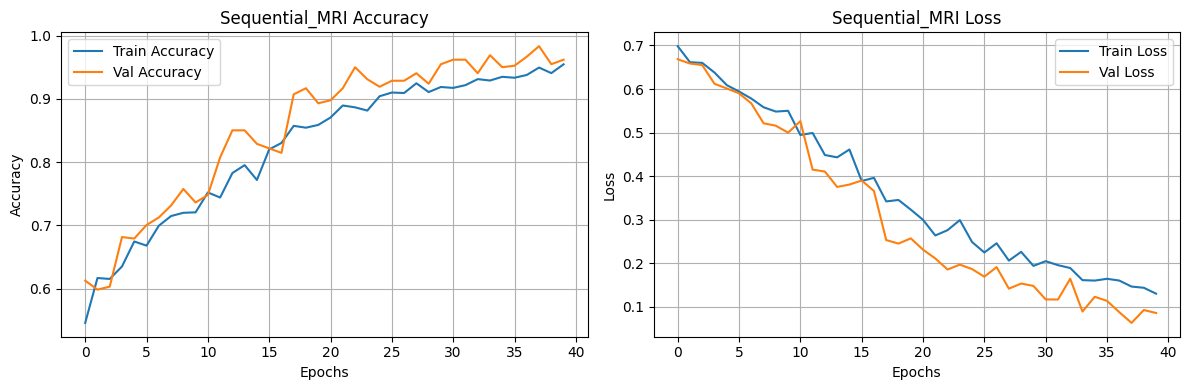

In [65]:
model_accuracies = {}


s_train, s_val = summarize_history(seq_mri_history, "Sequential_MRI")
s_test = evaluate_on_test(seq_mri_model, "Sequential_MRI")
plot_history(seq_mri_history, "Sequential_MRI")
model_accuracies["Sequential_MRI"] = s_test

